# Predicting Daily Oil Price Movements Using Machine Learning

This notebook explores the development and evaluation of machine learning models to predict daily up or down movements in oil prices, with the intent that these models with generalize nicely to all other kinds of commodities. Leveraging financial data and technical indicators, we aim to create a robust binary classification model capable of determining whether oil prices will increase or decrease on a given day.

The purpose of this project is to:
1. Collect and preprocess historical oil price data.
2. Engineer meaningful features to capture trends and volatility.
3. Implement machine learning models using both TensorFlow and PyTorch.
4. Compare the performance of different architectures, including sequential and residual attention-based models.
5. Evaluate the models using backtesting and visualizations of binary classification results.


In [1104]:
import yfinance as yf
import pandas as pd
import datetime as dt
import ta

## Data Collection and Processing

### Data Source
The historical oil price data used in this project was collected from Yahoo Finance (`yfinance`), which provides comprehensive data on open, high, low, close, and volume for oil commodities. The data spans a specified period and is downloaded programmatically for consistency and ease of updates.

### Data Preprocessing
1. **Feature Selection**:
   - Technical indicators were computed to capture trends, momentum, and volatility. These include:
     - Moving Averages (SMA_20, SMA_50)
     - Relative Strength Index (RSI)
     - MACD (and MACD Signal and Histogram)
     - Bollinger Bands (Upper, Lower, and Middle)
     - Stochastic Oscillator (%K, %D)
     - Average True Range (ATR)

2. **Lagged Features**:
   - Previous day's price data (e.g., `closeShift`, `openShift`) was added to provide historical context.

3. **Target Variable**:
   - The target variable (`UpDown`) is a binary label indicating whether the closing price increased compared to the previous day.

4. **Normalization**:
   - Features were scaled using MinMaxScaler to ensure compatibility with neural networks and to prevent dominance by larger-scaled features.

5. **Train-Test Split**:
   - The data was split into training and testing sets, with the testing set used to simulate unseen data during backtesting.


In [1105]:
# This is the continuous WTI crude futures ticker on Yahoo
oil_ticker = yf.Ticker("CL=F")

# historical dataq for this ticker, period 2 years, with 1 day intervals
df = oil_ticker.history(period="2y", interval="1d")

# get OHLCV data for this ticker 
df = df[['Open','High','Low','Close','Volume']] 

In [1106]:
# can't rely on present data
df['previousClose'] = df['Close'].shift(1)
df['closeShift'] = df['Close'].shift(1)
df['openShift'] = df['Open'].shift(1)
df['highShift'] = df['High'].shift(1)
df['lowShift'] = df['Low'].shift(1)

Technical Indicators:

In [1107]:
df['SMA_20'] = df['closeShift'].rolling(window=20).mean()
df['SMA_50'] = df['closeShift'].rolling(window=50).mean()

df['RSI'] = ta.momentum.RSIIndicator(
    close=df['closeShift'], window=14
).rsi()

macd = ta.trend.MACD(close=df["Close"], window_slow=26, window_fast=12, window_sign=9)
df["MACD"] = macd.macd()
df["MACD_Signal"] = macd.macd_signal()
df["MACD_Hist"] = macd.macd_diff()

bb = ta.volatility.BollingerBands(close=df['closeShift'], window=20, window_dev=2)
df['BB_Upper'] = bb.bollinger_hband()
df['BB_Middle'] = bb.bollinger_mavg()
df['BB_Lower'] = bb.bollinger_lband()

# Stochastic %K
df['%K'] = (df['closeShift'] - df['lowShift'].rolling(window=14).min()) / \
           (df['highShift'].rolling(window=14).max() - df['lowShift'].rolling(window=14).min()) * 100
# Stochastic %D (3-period SMA of %K)
df['%D'] = df['%K'].rolling(window=3).mean()

# Average True Range (ATR): Volatility indicator measuring the average range of price movement over the last 14 periods
atr = ta.volatility.AverageTrueRange(high=df['highShift'], low=df['lowShift'], close=df['closeShift'], window=14)
df['ATR'] = atr.average_true_range()

df['UpDown'] = (df['Close'] > df['previousClose']).astype(int)
df['PercentChange'] = (df['Close'] - df['previousClose']) / df['previousClose'] * 100
df['Volume_SMA_20'] = df['Volume'].rolling(window=20).mean()


In [1108]:
df.dropna(inplace=True)

df

,Open,High,Low,Close,Volume,previousClose,closeShift,openShift,highShift,lowShift,...,MACD_Hist,BB_Upper,BB_Middle,BB_Lower,%K,%D,ATR,UpDown,PercentChange,Volume_SMA_20
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-24 00:00:00-04:00,69.510002,70.379997,66.820000,69.260002,380852,69.959999,69.959999,69.949997,71.669998,69.139999,...,-0.346565,82.562686,73.917001,65.271316,34.720550,35.334908,3.109646,0,-1.000567,337803.65
2023-03-27 00:00:00-04:00,69.419998,73.099998,69.129997,72.809998,353598,69.260002,69.260002,69.510002,70.379997,66.820000,...,-0.019725,82.363551,73.564001,64.764451,30.558855,35.196185,3.141814,1,5.125607,342179.00
2023-03-28 00:00:00-04:00,72.860001,73.930000,72.190002,73.199997,328472,72.809998,72.809998,69.419998,73.099998,69.129997,...,0.228739,82.170811,73.420501,64.670191,62.338580,42.539328,3.200970,1,0.535640,343597.95
2023-03-29 00:00:00-04:00,73.610001,74.370003,72.760002,72.970001,312669,73.199997,73.199997,72.860001,73.930000,72.190002,...,0.374964,81.818389,73.228001,64.637613,65.136281,52.677905,3.096615,0,-0.314202,342125.35
2023-03-30 00:00:00-04:00,72.980003,74.629997,72.610001,74.370003,269743,72.970001,72.970001,73.610001,74.370003,72.760002,...,0.552611,81.334866,72.992001,64.649135,66.292131,64.588997,2.990428,1,1.918599,342595.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-06 00:00:00-05:00,74.050003,74.989998,73.199997,73.559998,306042,73.959999,73.959999,73.129997,74.349998,72.699997,...,0.447164,73.303607,70.208000,67.112393,93.423282,91.263511,1.620543,0,-0.540835,231579.00
2025-01-07 00:00:00-05:00,73.440002,74.529999,73.110001,74.250000,277328,73.559998,73.559998,74.050003,74.989998,73.199997,...,0.474382,73.761166,70.471000,67.180833,78.234393,86.786045,1.632647,1,0.938013,228365.75
2025-01-08 00:00:00-05:00,74.519997,75.290001,73.160004,73.320000,328617,74.250000,74.250000,73.440002,74.529999,73.110001,...,0.402016,74.146818,70.823500,67.500181,88.736714,86.798130,1.617458,0,-1.252526,229942.35


Process Dataset(s)

In [1109]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# we use the features (indep variables) to predict a dependent variable, target
features = [
    # 'Open', 
    # 'High', 
    # 'Low', 
    # 'Volume', 
    'previousClose', 
    'closeShift',
       'openShift', 
       'highShift', 
       'lowShift', 
       'SMA_20', 
       'SMA_50', 
       'RSI', 
       'MACD', 
       'MACD_Signal', 
       'MACD_Hist', 
       'BB_Upper', 
       'BB_Middle', 
       'BB_Lower', 
       '%K',
       '%D', 
       'ATR', 
       #'Close', 
       'PercentChange', 
       'Volume_SMA_20'
       ] 

target = 'UpDown'

X = df[features]
y = df[[target]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

scaler_X = MinMaxScaler(feature_range=(0, 1))
#scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()




## Model Implementation

### TensorFlow Sequential Model
A TensorFlow model was implemented as a baseline to compare against PyTorch models. The architecture consisted of multiple dense layers with ReLU activations and dropout for regularization. The model used binary cross-entropy as the loss function and the Adam optimizer for efficient training.

In [1110]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(16, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [1111]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x=X_train_scaled,
    y=y_train,
    epochs=256,
    verbose=1,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluate on test data
predictions = model.predict(X_test_scaled)
predictions_binary = (predictions > 0.5).astype(int)


Epoch 1/256


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5054 - loss: 0.6974 - val_accuracy: 0.5479 - val_loss: 0.6950
Epoch 2/256
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4829 - loss: 0.6971 - val_accuracy: 0.4247 - val_loss: 0.6942
Epoch 3/256
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5232 - loss: 0.6920 - val_accuracy: 0.4932 - val_loss: 0.6929
Epoch 4/256
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4970 - loss: 0.6891 - val_accuracy: 0.5205 - val_loss: 0.6925
Epoch 5/256
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4671 - loss: 0.6933 - val_accuracy: 0.5068 - val_loss: 0.6921
Epoch 6/256
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5250 - loss: 0.6879 - val_accuracy: 0.5205 - val_loss: 0.6919
Epoch 7/256
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5311 - loss: 0.6883 - val_accuracy: 0.5616 - val_loss: 0.6902
Epoch 8/256
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4874 - loss: 0.6891 - val_accuracy: 0.5753 - val_loss: 0.

In [1112]:
from sklearn.metrics import accuracy_score, classification_report
my_accuracy = accuracy_score(y_test, predictions_binary)
print(f"Test Accuracy: {my_accuracy:.2f}")

# Print classification report
print(classification_report(y_test, predictions_binary))

Test Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.93      0.57      0.70        44
           1       0.70      0.96      0.81        47

    accuracy                           0.77        91
   macro avg       0.81      0.76      0.76        91
weighted avg       0.81      0.77      0.76        91



In [1113]:
import pandas as pd

# Add predictions to the test DataFrame
X_test['Predicted'] = predictions_binary.flatten()
X_test['Actual'] = y_test

# Compare predicted and actual price changes
X_test['Correct'] = X_test['Predicted'] == X_test['Actual']

# Calculate accuracy in backtesting
backtest_accuracy = X_test['Correct'].mean() * 100
print(f"Backtest Accuracy: {backtest_accuracy:.2f}%")

Backtest Accuracy: 76.92%


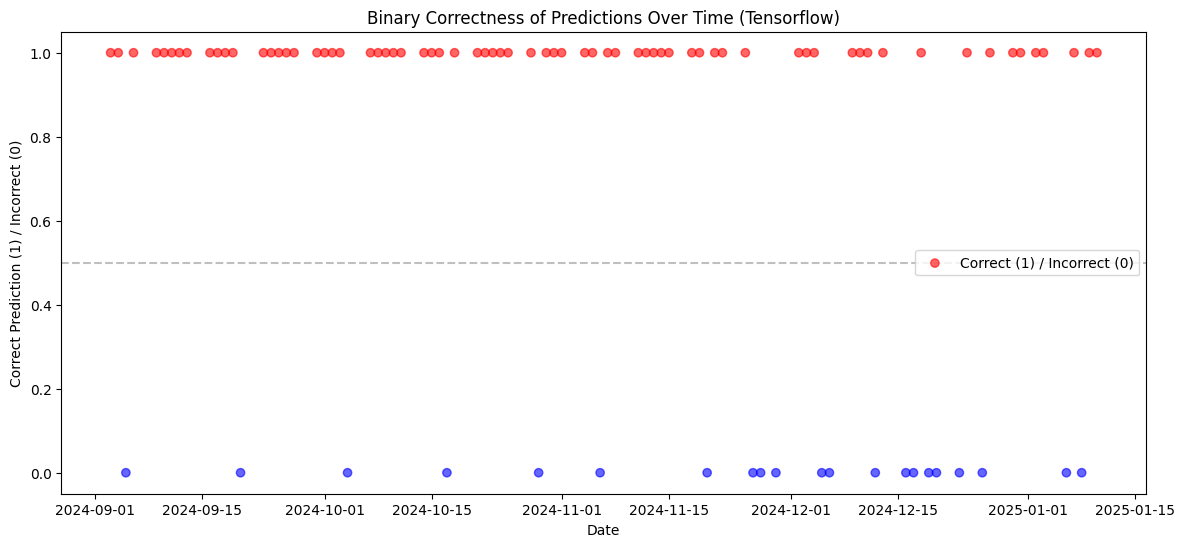

In [1114]:
import numpy as np
import pandas as pd

# Ensure predictions and actual values are binary and aligned
X_test['Correct'] = (predictions_binary.flatten() == y_test).astype(int)


import matplotlib.pyplot as plt

# Create a time axis (use your test data index)
time_axis = X_test.index

# Plot binary correct/incorrect values
plt.figure(figsize=(14, 6))
plt.scatter(time_axis, X_test['Correct'], c=X_test['Correct'], cmap='bwr', alpha=0.6, label='Correct (1) / Incorrect (0)')
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)  # Threshold line for better visibility
plt.xlabel('Date')
plt.ylabel('Correct Prediction (1) / Incorrect (0)')
plt.title('Binary Correctness of Predictions Over Time (Tensorflow)')
plt.legend()
plt.show()

### PyTorch Sequential Model
A PyTorch model using the `Sequential` API was created to replicate the TensorFlow model. The architecture included:
- Fully connected layers: `input_size → 256 → 128 → 128 → 64 → 32 → 1`
- ReLU activations for non-linearity
- Dropout layers to prevent overfitting
- Sigmoid activation in the final layer for binary classification

In [1115]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [1116]:
class PriceData(Dataset):
    def __init__(self, features, target):
        self.features = features  # Already scaled as a NumPy array
        self.target = target     # Convert target to NumPy array


    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        x = torch.tensor(self.features[index], dtype=torch.float32)
        y = torch.tensor(self.target[index], dtype=torch.float32)  
        return x, y

In [1117]:
train_dataset = PriceData(X_train_scaled, y_train)
test_dataset = PriceData(X_test_scaled, y_test)

In [1118]:
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [1119]:
# sequential model

import torch.nn as nn

class PricePredictionModel(nn.Module):
    def __init__(self, input_size):
        super(PricePredictionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256), 
            nn.ReLU(),
            nn.Linear(256, 128),        
            nn.ReLU(),
            nn.Linear(128, 128),        
            nn.ReLU(),
            nn.Linear(128, 64),         
            nn.ReLU(),
            nn.Linear(64, 32),         
            nn.ReLU(),
            nn.Linear(32, 1),           
            nn.Sigmoid()                # Sigmoid for binary classification
        )
    
    def forward(self, x):
        return self.model(x)
    
input_size = len(features)  # Should be 24
print(f"Input size: {input_size}")

# Instantiate the model with the correct input size
model = PricePredictionModel(input_size=input_size)
model.to(device)

torch.save(model.state_dict(), "model_weights.pth")

Input size: 19


### PyTorch Residual Model (Work in Progress)
A more advanced PyTorch model incorporating residual connections and an attention mechanism is under development. Residual connections help stabilize training and allow deeper architectures, while attention mechanisms dynamically emphasize the most relevant features for prediction. This model builds on the sequential architecture with added complexity to capture deeper patterns in the data.

In [1120]:
# residual model (in development)

# import torch.nn as nn

# class ResidualAttentionPricePredictionModel(nn.Module):
#     def __init__(self, input_size):
#         super(ResidualAttentionPricePredictionModel, self).__init__()
        
#         # Attention mechanism
#         self.attention = nn.Linear(input_size, input_size)
        
#         # Fully connected layers
#         self.fc1 = nn.Linear(input_size, 128)  # Increased layer size
#         self.fc2 = nn.Linear(128, 128)        # Additional layer
#         self.fc3 = nn.Linear(128, 64)
#         self.fc4 = nn.Linear(64, 32)          # Additional layer
#         self.fc5 = nn.Linear(32, 1)           # Final layer
        
#         # Batch normalization for stability
#         self.bn1 = nn.BatchNorm1d(128)
#         self.bn2 = nn.BatchNorm1d(64)
#         self.bn3 = nn.BatchNorm1d(32)
        
#         # Activation and regularization
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(p=0.2)  # 20% dropout
#         self.sigmoid = nn.Sigmoid()       # Sigmoid for binary classification

#     def forward(self, x):
#         # Attention mechanism
#         attention_weights = torch.softmax(self.attention(x), dim=1)
#         x = x * attention_weights  # Weighted features
        
#         # First layer
#         x = self.relu(self.fc1(x))
#         x = self.bn1(x)
#         x = self.dropout(x)
#         # Residual connection (fc1 to fc2)
#         residual = x
#         x = self.relu(self.fc2(x)) + residual  # Add skip connection
#         x = self.bn1(x)
#         x = self.dropout(x)

#         # Remaining layers
#         x = self.relu(self.fc3(x))
#         x = self.bn2(x)
#         x = self.dropout(x)
        
#         x = self.relu(self.fc4(x))
#         x = self.bn3(x)
#         x = self.dropout(x)
        
#         return self.sigmoid(self.fc5(x))  # Output layer



# # Dynamically compute input size
# input_size = len(features)  # Should be 24
# print(f"Input size: {input_size}")

# # Instantiate the model with the correct input size
# model = PricePredictionModel(input_size=input_size)
# model.to(device)

# torch.save(model.state_dict(), "model_weights.pth")

In [1121]:
input_size = len(features)
model = PricePredictionModel(input_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training the Model with Early Stopping

### Purpose of the Training Loop
The training loop is designed to iteratively optimize the model's parameters to minimize the binary cross-entropy loss while ensuring generalization to unseen data. To prevent overfitting and improve efficiency, early stopping is implemented to halt training when validation performance no longer improves.

---

### **Features of the Training Loop**

#### **1. Training Phase**
- **Objective**: Minimize the loss function by updating model weights using backpropagation.
- **Process**:
  - The model is set to training mode using `model.train()`.
  - For each batch in the `train_loader`:
    - Data is sent to the appropriate device (CPU/GPU).
    - Predictions are generated using the current model.
    - Loss is calculated using the criterion (`BCELoss` for binary classification).
    - Gradients are computed using `loss.backward()` and optimizer steps are performed to update weights.

#### **2. Validation Phase**
- **Objective**: Evaluate the model's performance on unseen data to track overfitting and generalization.
- **Process**:
  - The model is set to evaluation mode using `model.eval()` (disables dropout and batch normalization updates).
  - For each batch in the `test_loader`:
    - Predictions are generated without gradient computation using `torch.no_grad()`.
    - Validation loss is accumulated and averaged over all batches.

#### **3. Early Stopping**
- **Purpose**: Prevent overfitting by stopping training when validation loss does not improve for a specified number of epochs (`patience`).
- **Implementation**:
  - The best validation loss is tracked, and the model is saved whenever validation loss improves.
  - If validation loss fails to improve for `patience` consecutive epochs, training is stopped early to save time and computational resources.

#### **4. Model Checkpointing**
- The model's weights are saved whenever validation loss improves, ensuring that the best version of the model is retained for deployment or further evaluation.


In [1122]:
# Training loop

# Define early stopping parameters
best_loss = float('inf')  # Initialize the best validation loss
patience = 10             # Number of epochs to wait before stopping
no_improve_epochs = 0     # Counter for no improvement

# Training loop
epochs = 64
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    # Training phase
    for features, target in train_loader:
        features, target = features.to(device), target.to(device)
        target = target.view(-1, 1)  # Reshape target for BCELoss

        # Forward pass
        predictions = model(features)
        loss = criterion(predictions, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Compute training loss
    train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for features, target in test_loader:
            features, target = features.to(device), target.to(device)
            target = target.view(-1, 1)

            # Forward pass
            predictions = model(features)
            loss = criterion(predictions, target)
            val_loss += loss.item()

    val_loss /= len(test_loader)  # Average validation loss
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
        print(f"Validation loss improved. Model saved.")
    else:
        no_improve_epochs += 1
        print(f"No improvement for {no_improve_epochs} epochs.")

        if no_improve_epochs >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/64, Training Loss: 0.6931
Epoch 1/64, Validation Loss: 0.6913
Validation loss improved. Model saved.
Epoch 2/64, Training Loss: 0.6882
Epoch 2/64, Validation Loss: 0.6838
Validation loss improved. Model saved.
Epoch 3/64, Training Loss: 0.6642
Epoch 3/64, Validation Loss: 0.6612
Validation loss improved. Model saved.
Epoch 4/64, Training Loss: 0.5942
Epoch 4/64, Validation Loss: 0.6280
Validation loss improved. Model saved.
Epoch 5/64, Training Loss: 0.4247
Epoch 5/64, Validation Loss: 0.4691
Validation loss improved. Model saved.
Epoch 6/64, Training Loss: 0.2577
Epoch 6/64, Validation Loss: 0.4044
Validation loss improved. Model saved.
Epoch 7/64, Training Loss: 0.2030
Epoch 7/64, Validation Loss: 0.3813
Validation loss improved. Model saved.
Epoch 8/64, Training Loss: 0.1195
Epoch 8/64, Validation Loss: 0.4512
No improvement for 1 epochs.
Epoch 9/64, Training Loss: 0.1235


Epoch 9/64, Validation Loss: 0.4033
No improvement for 2 epochs.
Epoch 10/64, Training Loss: 0.1436
Epoch 10/64, Validation Loss: 0.1149
Validation loss improved. Model saved.
Epoch 11/64, Training Loss: 0.1209
Epoch 11/64, Validation Loss: 0.4316
No improvement for 1 epochs.
Epoch 12/64, Training Loss: 0.0765
Epoch 12/64, Validation Loss: 0.2526
No improvement for 2 epochs.
Epoch 13/64, Training Loss: 0.0639
Epoch 13/64, Validation Loss: 0.3960
No improvement for 3 epochs.
Epoch 14/64, Training Loss: 0.0803
Epoch 14/64, Validation Loss: 0.1742
No improvement for 4 epochs.
Epoch 15/64, Training Loss: 0.0565
Epoch 15/64, Validation Loss: 0.4950
No improvement for 5 epochs.
Epoch 16/64, Training Loss: 0.0805
Epoch 16/64, Validation Loss: 0.2242
No improvement for 6 epochs.
Epoch 17/64, Training Loss: 0.0980
Epoch 17/64, Validation Loss: 0.2373
No improvement for 7 epochs.
Epoch 18/64, Training Loss: 0.1470
Epoch 18/64, Validation Loss: 0.4429
No improvement for 8 epochs.
Epoch 19/64, Tra

## Backtesting and Results

### Evaluation Metrics
The models were evaluated using:
- **Binary Accuracy**: The proportion of correct up/down predictions.
- **Loss**: Binary cross-entropy loss for training and validation sets.
- **Backtesting**: Simulated trading performance using model predictions to assess real-world applicability.

### Backtesting Process
1. The model's predictions were applied to the test set, simulating daily price movements.
2. Binary predictions (`1` for up, `0` for down) were compared against actual price movements (`UpDown`).

### Binary Classification Results
Visualizations include:
- **Binary Classification Graphs**:
  - Scatter plots showing whether the model's predictions matched actual results over time.
  - Correct predictions (`1`) and incorrect predictions (`0`) are color-coded for clarity.


In [1123]:
import pandas as pd
import numpy as np
import torch

# Collect predictions and actual values
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for features, target in test_loader:
        features, target = features.to(device), target.to(device)
        outputs = model(features)
        predicted = (outputs > 0.5).cpu().numpy().flatten()  # Convert to binary predictions
        all_preds.extend(predicted)
        all_labels.extend(target.cpu().numpy().flatten())

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate correctness
correctness = (all_preds == all_labels).astype(int)  # Binary array: 1 for correct, 0 for incorrect



In [1124]:
X_test['Predicted'] = all_preds
X_test['Actual'] = all_labels
X_test['Correct'] = correctness

# Calculate backtest accuracy
backtest_accuracy = X_test['Correct'].mean() * 100
print(f"Backtest Accuracy: {backtest_accuracy:.2f}%")


Backtest Accuracy: 86.81%


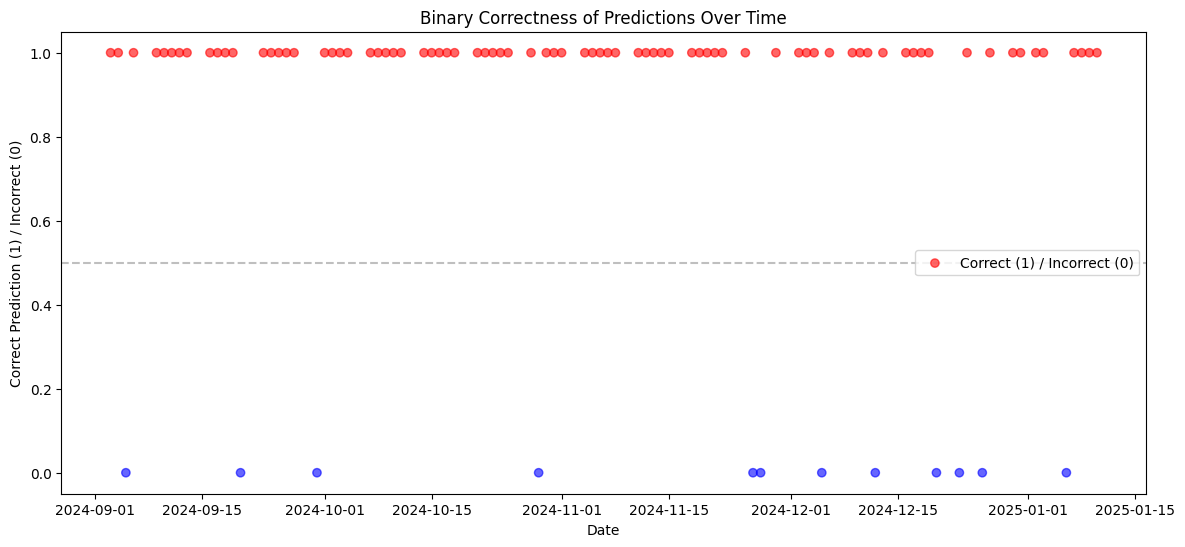

In [1125]:
import matplotlib.pyplot as plt

# Create a time axis (use your test data index)
time_axis = X_test.index

# Plot binary correctness
plt.figure(figsize=(14, 6))
plt.scatter(time_axis, X_test['Correct'], c=X_test['Correct'], cmap='bwr', alpha=0.6, label='Correct (1) / Incorrect (0)')
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)  # Threshold line
plt.xlabel('Date')
plt.ylabel('Correct Prediction (1) / Incorrect (0)')
plt.title('Binary Correctness of Predictions Over Time')
plt.legend()
plt.show()



## Testing and Results

### Evaluation Metrics
The model was evaluated on an unseen dataset using the following metrics:
- **Binary Accuracy**: The percentage of correct up/down predictions.
- **Binary Cross-Entropy Loss**: Tracks the model's error on the unseen dataset.
- **Prediction Correctness**: Measures how well the predicted values align with actual price movements.

---

### Testing Process
1. **Unseen Dataset**:
   - The model was applied to an entirely new dataset (unseen during training) to simulate real-world usage.
   - Features in the unseen dataset were preprocessed in the same way as the training data to maintain consistency.

2. **Prediction Generation**:
   - The model predicted whether the closing price would move up (`1`) or down (`0`) compared to the previous day.
   - Predictions were generated using the saved model (`best_model.pth`) in evaluation mode.

3. **Comparison with Actual Values**:
   - Predicted labels were compared with the actual `UpDown` values, which indicate the true direction of daily price movements.

---

### Testing Results
#### Visualizations:
1. **Binary Classification Graphs**:
   - Scatter plots were used to visualize the model’s predictions over time:
     - Correct predictions (`1`) are shown in red.
     - Incorrect predictions (`0`) are shown in blue.
   - This visualization highlights the model's strengths and weaknesses in capturing daily fluctuations.

2. **Accuracy Trends**:
   - Accuracy trends over time were plotted to understand the model's performance during different periods.

In [1126]:

new_data = oil_ticker.history(start="2018-01-01", end="2021-01-01")

new_data = new_data[['Open','High','Low','Close','Volume']]

new_data['previousClose'] = new_data['Close'].shift(1)
new_data['closeShift'] = new_data['Close'].shift(1)
new_data['openShift'] = new_data['Open'].shift(1)
new_data['highShift'] = new_data['High'].shift(1)
new_data['lowShift'] = new_data['Low'].shift(1)

new_data['SMA_20'] = new_data['closeShift'].rolling(window=20).mean()
new_data['SMA_50'] = new_data['closeShift'].rolling(window=50).mean()

new_data['RSI'] = ta.momentum.RSIIndicator(
    close=new_data['closeShift'], window=14
).rsi()

macd = ta.trend.MACD(close=new_data["Close"], window_slow=26, window_fast=12, window_sign=9)
new_data["MACD"] = macd.macd()
new_data["MACD_Signal"] = macd.macd_signal()
new_data["MACD_Hist"] = macd.macd_diff()

bb = ta.volatility.BollingerBands(close=new_data['closeShift'], window=20, window_dev=2)
new_data['BB_Upper'] = bb.bollinger_hband()
new_data['BB_Middle'] = bb.bollinger_mavg()
new_data['BB_Lower'] = bb.bollinger_lband()

# Stochastic %K
new_data['%K'] = (new_data['closeShift'] - new_data['lowShift'].rolling(window=14).min()) / \
           (new_data['highShift'].rolling(window=14).max() - new_data['lowShift'].rolling(window=14).min()) * 100
# Stochastic %D (3-period SMA of %K)
new_data['%D'] = new_data['%K'].rolling(window=3).mean()

# Average True Range (ATR): Volatility indicator measuring the average range of price movement over the last 14 periods
atr = ta.volatility.AverageTrueRange(high=new_data['highShift'], low=new_data['lowShift'], close=new_data['closeShift'], window=14)
new_data['ATR'] = atr.average_true_range()

new_data['UpDown'] = (new_data['Close'] > new_data['previousClose']).astype(int)
new_data['PercentChange'] = (new_data['Close'] - new_data['previousClose']) / new_data['previousClose'] * 100
new_data['Volume_SMA_20'] = new_data['Volume'].rolling(window=20).mean()

new_data.dropna(inplace=True)

new_data


,Open,High,Low,Close,Volume,previousClose,closeShift,openShift,highShift,lowShift,...,MACD_Hist,BB_Upper,BB_Middle,BB_Lower,%K,%D,ATR,UpDown,PercentChange,Volume_SMA_20
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-15 00:00:00-04:00,60.950001,61.540001,60.820000,61.189999,430201,60.959999,60.959999,60.869999,61.330002,60.110001,...,-0.062685,63.751880,61.791500,59.831120,23.543100,24.708614,1.602069,1,0.377296,596882.60
2018-03-16 00:00:00-04:00,61.189999,62.540001,61.080002,62.340000,202493,61.189999,61.189999,60.950001,61.540001,60.820000,...,0.030546,63.725740,61.821000,59.916260,28.904399,23.387697,1.539064,1,1.879395,589987.20
2018-03-19 00:00:00-04:00,62.230000,62.349998,61.360001,62.060001,115962,62.340000,62.340000,61.189999,62.540001,61.080002,...,0.072268,63.775110,61.871000,59.966890,57.869220,36.772240,1.533416,0,-0.449148,586726.35
2018-03-20 00:00:00-04:00,62.099998,63.810001,62.080002,63.400002,717709,62.060001,62.060001,62.230000,62.349998,61.360001,...,0.182738,63.793691,61.890000,59.986309,60.458507,49.077375,1.494601,1,2.159201,582887.75
2018-03-21 00:00:00-04:00,63.720001,65.550003,63.580002,65.169998,763768,63.400002,63.400002,62.099998,63.810001,62.080002,...,0.357530,63.979334,61.965000,59.950666,89.378244,69.235324,1.512844,1,2.791793,597729.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24 00:00:00-05:00,48.090000,48.619999,47.560001,48.230000,167390,48.119999,48.119999,46.790001,48.500000,46.160000,...,-0.077650,48.982237,46.565499,44.148762,73.210153,65.187048,1.536830,1,0.228596,324651.00
2020-12-28 00:00:00-05:00,48.230000,48.959999,47.500000,47.619999,238462,48.230000,48.230000,48.090000,48.619999,47.560001,...,-0.136150,49.178436,46.691500,44.204563,75.750584,66.681004,1.502770,0,-1.264774,318317.70
2020-12-29 00:00:00-05:00,47.720001,48.349998,47.680000,48.000000,213778,47.619999,47.619999,48.230000,48.959999,47.500000,...,-0.155610,49.254409,46.796000,44.337590,61.662804,70.207847,1.499715,1,0.797986,310468.85


In [1127]:
features = [
    # 'Open', 
    # 'High', 
    # 'Low', 
    # 'Volume', 
    'previousClose', 
    'closeShift',
       'openShift', 
       'highShift', 
       'lowShift', 
       'SMA_20', 
       'SMA_50', 
       'RSI', 
       'MACD', 
       'MACD_Signal', 
       'MACD_Hist', 
       'BB_Upper', 
       'BB_Middle', 
       'BB_Lower', 
       '%K',
       '%D', 
       'ATR', 
    #    'Close', 
       'PercentChange', 
       'Volume_SMA_20'
       ] 

scaled_new_data = scaler_X.transform(new_data[features])


In [1128]:
from torch.utils.data import DataLoader

# Prepare new data for the dataset
new_dataset = PriceData(features, None)  # `None` for the target as we're predicting
new_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)  # Adjust batch size as needed

In [1129]:
model.load_state_dict(torch.load("model_weights.pth"))  # Path to your saved model weights
model.eval()  # Set the model to evaluation mode

/var/folders/nc/_42w8t5d2g96n89wq7mhrkw80000gn/T/ipykernel_28528/702396257.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weight

PricePredictionModel(
  (model): Sequential(
    (0): Linear(in_features=19, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

In [1130]:
new_data_tensor = torch.tensor(scaled_new_data, dtype=torch.float32).to(device)

# Predict using the model
with torch.no_grad():
    predictions = model(new_data_tensor).cpu().numpy()

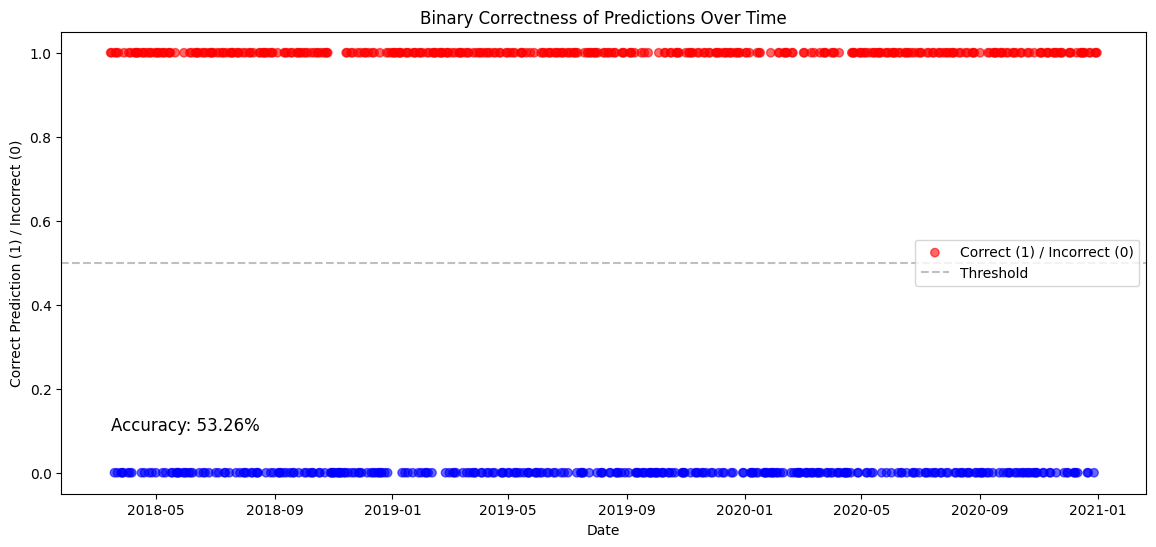

In [1131]:
import matplotlib.pyplot as plt

# Define binary correctness
new_data['UpDown'] = (new_data['Close'] > new_data['previousClose']).astype(int)
new_data['Predictions'] = predictions
binary_predictions = (predictions >= 0.5).astype(int)
new_data['BinaryPredictions'] = binary_predictions
new_data['Correct'] = (new_data['BinaryPredictions'] == new_data['UpDown']).astype(int)

# Plot binary correctness over time
time_axis = new_data.index

plt.figure(figsize=(14, 6))
plt.scatter(
    time_axis,
    new_data['Correct'],
    c=new_data['Correct'],
    cmap='bwr',
    alpha=0.6,
    label='Correct (1) / Incorrect (0)'
)
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Threshold')
plt.xlabel('Date')
plt.ylabel('Correct Prediction (1) / Incorrect (0)')
plt.title('Binary Correctness of Predictions Over Time')
plt.legend()

# Add overall accuracy
accuracy = new_data['Correct'].mean() * 100
plt.text(time_axis[0], 0.1, f'Accuracy: {accuracy:.2f}%', fontsize=12, color='black')

plt.show()


